In [1]:
!pip install --quiet -r https://raw.githubusercontent.com/JoaquinLCalvo/Explained-CNN-SSL/refs/heads/explainability/requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as FT
import torch.optim as optim
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm
from captum.attr import IntegratedGradients
import wandb
from einops import rearrange


sns.set()

/home/leo/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
## Wandb Initialization

# CORRECT VALUES

wandb.init(
    project="Explained-CNN-SimCLR",  
    config={
        "backbone": "Resnet50",
        "epochs": 5,
        "batch_size": 256,
        "learning_rate": 1e-3,
        "temperature": 0.07,
        "hidden_dim": 128
    }
)

In [ ]:
## Data Preparation

# Path configurations
DATASET_PATH = "data/"
NUM_WORKERS = os.cpu_count()

# Data augmentations for SimCLR
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets for contrastive learning
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=contrast_transforms
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=contrast_transforms
)

# IS THIS STILL USEFUL?

# Dataset for the MLP 
test_data = STL10(
    root=DATASET_PATH,
    split="test",
    download=True,
    transform=transforms.Compose([
        transforms.Resize(size=96),
        transforms.ToTensor()])
)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
## SimCLR model definition

class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim=128, num_classes=10, lr=1e-3, temperature=0.07, weight_decay=1e-4, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()

        # INTERNAL NOTES
        # 1. In the future, try with other backbones (could be Resnet50, could be some EfficientNet)
        # 2. Since SimCLR learns representations directly from the data, I'm not using the pre-trained weights by now
        # to avoid the bias learned from ImageNet-like datasets. However, this should also be tested.
        # Tip: for larger datasets, pretrained=False should work better (because of what I've just exposed)
        # while for small datasets, the pretrained weights might provide a performance boost
        # Define ResNet backbone

        # Base model f(.)
        self.encoder = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        self.encoder.fc = nn.Identity() #remove the classifier head
        
        # The MLP projection head for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max=self.hparams.max_epochs,
                                                         eta_min=self.hparams.lr / 50)
        return [optimizer], [scheduler]
    
    def contrastive_loss(self, z1, z2):
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        batch_size = z1.size(0)
        labels = torch.arange(batch_size).to(z1.device)
        logits = torch.mm(z1, z2.T) / self.hparams.temperature
        loss = F.cross_entropy(logits, labels)
        return loss

    def training_step(self, batch, batch_idx):
        (x1, x2), _ = batch  # Two augmented views
        z1 = self(x1)
        z2 = self(x2)
        loss = self.contrastive_loss(z1, z2)
        self.log("train_loss", loss)
        wandb.log({"train_loss": loss})
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch)
        self.log("train_loss", loss, on_epoch=True, logger=True)
        wandb.log({"train_loss": loss})
        return loss


In [ ]:
## Train SimCLR Model

def train_simclr(batch_size=256, max_epochs=100, **kwargs):
    wandb_logger = WandbLogger(project="Explained-CNN-SimCLR")
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=1,
        logger=wandb_logger,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, monitor="train_loss", mode="min"),
            LearningRateMonitor(logging_interval="epoch"),
        ]
    )
    train_loader = torch.utils.data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    model = SimCLR(num_classes=10, max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader)
    return model

# Train the SimCLR model
simclr_model = train_simclr(hidden_dim=128,
                            lr=1e-3,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=10)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | convnet    | ResNet | 11.5 M | train
1 | classifier | Linear | 1.3 K  | train
----------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.024    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Uncomment this section if you want to enable a separated Downstream Classifier.

#INTERNAL NOTES:
# The logic of this part is as follows: After training SimCLR (encoder + projection head),
# freeze the encoder and attach a new MLP Classifier.
# Then, we fine-tune the classifier for the downstream task (e.g., image classification).
# Hypothesis: a new classifier head to evaluate learned features could make it easier to separately
# analyze the quality of learned features.



# class FineTunedClassifier(pl.LightningModule):
#     def __init__(self, pretrained_encoder, num_classes=10, lr=1e-3, weight_decay=1e-4):
#         super().__init__()
#         self.encoder = pretrained_encoder
#         for param in self.encoder.parameters():
#             param.requires_grad = False  # Freeze encoder
#         self.classifier = nn.Linear(self.encoder.fc.in_features, num_classes)
#         self.save_hyperparameters()

#     def forward(self, x):
#         features = self.encoder(x)
#         logits = self.classifier(features)
#         return logits

#     def configure_optimizers(self):
#         optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
#         return optimizer

In [ ]:
## Save the model
# Path to save the model on Colab
simclr_model_save_path = "simclr_model.pth"

# Save the model's state_dict
torch.save(simclr_model.state_dict(), simclr_model_save_path)
print(f"Model saved to {simclr_model_save_path}")

# Download the model to your local machine
from google.colab import files
files.download(simclr_model_save_path)

#Log model artifacts to wandb
wandb.save(simclr_model_save_path)
wandb.log({"simclr_model": wandb.Artifact("simclr_model", type="model")})

In [ ]:
wandb.finish()

In [11]:
SAVED_MODELS_PATH = "saved_models"

simclr_model_path = os.path.join(SAVED_MODELS_PATH, "simclr_model.pth")
simclr_model = SimCLR()
simclr_model.load_state_dict(torch.load(simclr_model_path, weights_only=True))
simclr_model.eval()

mlp_model_path = os.path.join(SAVED_MODELS_PATH, "mlp_model.pth")
mlp_model = MLPClassifier()
mlp_model.load_state_dict(torch.load(mlp_model_path, weights_only=True))
mlp_model.eval()

EXAMPLES_FOLDER = "examples"
EXAMPLE_NUMBER = "2"
examples_image_folder_path = os.path.join(EXAMPLES_FOLDER, EXAMPLE_NUMBER)
os.makedirs(examples_image_folder_path, exist_ok=True)

EXAMPLE_IMAGE_NAME = "attributions.png"
examples_image_path = os.path.join(examples_image_folder_path, EXAMPLE_IMAGE_NAME)

EXAMPLES_COUNT = 5
class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
models = {
    'clr': simclr_model,
    'mlp': mlp_model
}

In [7]:
# Getting some example images from the dataset
def get_examples(size=EXAMPLES_COUNT):
    examples = []
    for i in range(size):
        image, label = test_data[i]
        examples.append({
            'img': image,
            'label': label
        })
    return examples

In [8]:
def get_attributions(model, examples: list):

    def forward_fn(inputs):
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(0)
        return model(inputs, classify=True)
    ig = IntegratedGradients(forward_fn)

    results = []
    for example in examples:
        input_tensor = example['img']
        input_tensor = input_tensor.unsqueeze(0)

        with torch.no_grad():
            logits = model(input_tensor, classify=True)
            target_class = logits.argmax(dim=-1).item()

        attributions, delta = ig.attribute(
            inputs=input_tensor, target=target_class, return_convergence_delta=True
        )
        attributions_np = attributions[0].cpu().detach().numpy()
        attributions_np = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())
        results.append({
            'prediction': target_class,
            'attr': attributions_np.transpose(1, 2, 0)
        })
    return results

In [9]:
def show_attributions(attributions, model_names, save_fig=False):
    if not isinstance(attributions, list):
        attributions = [attributions]
    fig, ax = plt.subplots(len(attributions), 3, figsize=(10, 5 * len(attributions)))
    for idx, ex in enumerate(attributions):
        img = ex['img']
        label = ex['label']

        img = img.detach()
        img = FT.to_pil_image(img)
        
        ax[idx, 0].imshow(np.asarray(img))
        ax[idx, 0].set_title(f'Original image class is {class_names[label]}')
        
        for jdx, model_name in enumerate(model_names):
            prediction = ex[model_name]['prediction']
            attr = ex[model_name]['attr']
            ax[idx, jdx + 1].imshow(attr)
            ax[idx, jdx + 1].set_title(f'Attributions of {model_name} (predicted: {class_names[prediction]})')
    plt.tight_layout()
    if save_fig:
        plt.savefig(examples_image_path)
    plt.show()

In [10]:
examples = get_examples()
models_attributions = {}
for model_name in models:
    models_attributions[model_name] = get_attributions(model=models[model_name], examples=examples)
    for idx in range(len(examples)):
        examples[idx][model_name] = {}
        examples[idx][model_name]['prediction'] = models_attributions[model_name][idx]['prediction']
        examples[idx][model_name]['attr'] = models_attributions[model_name][idx]['attr']

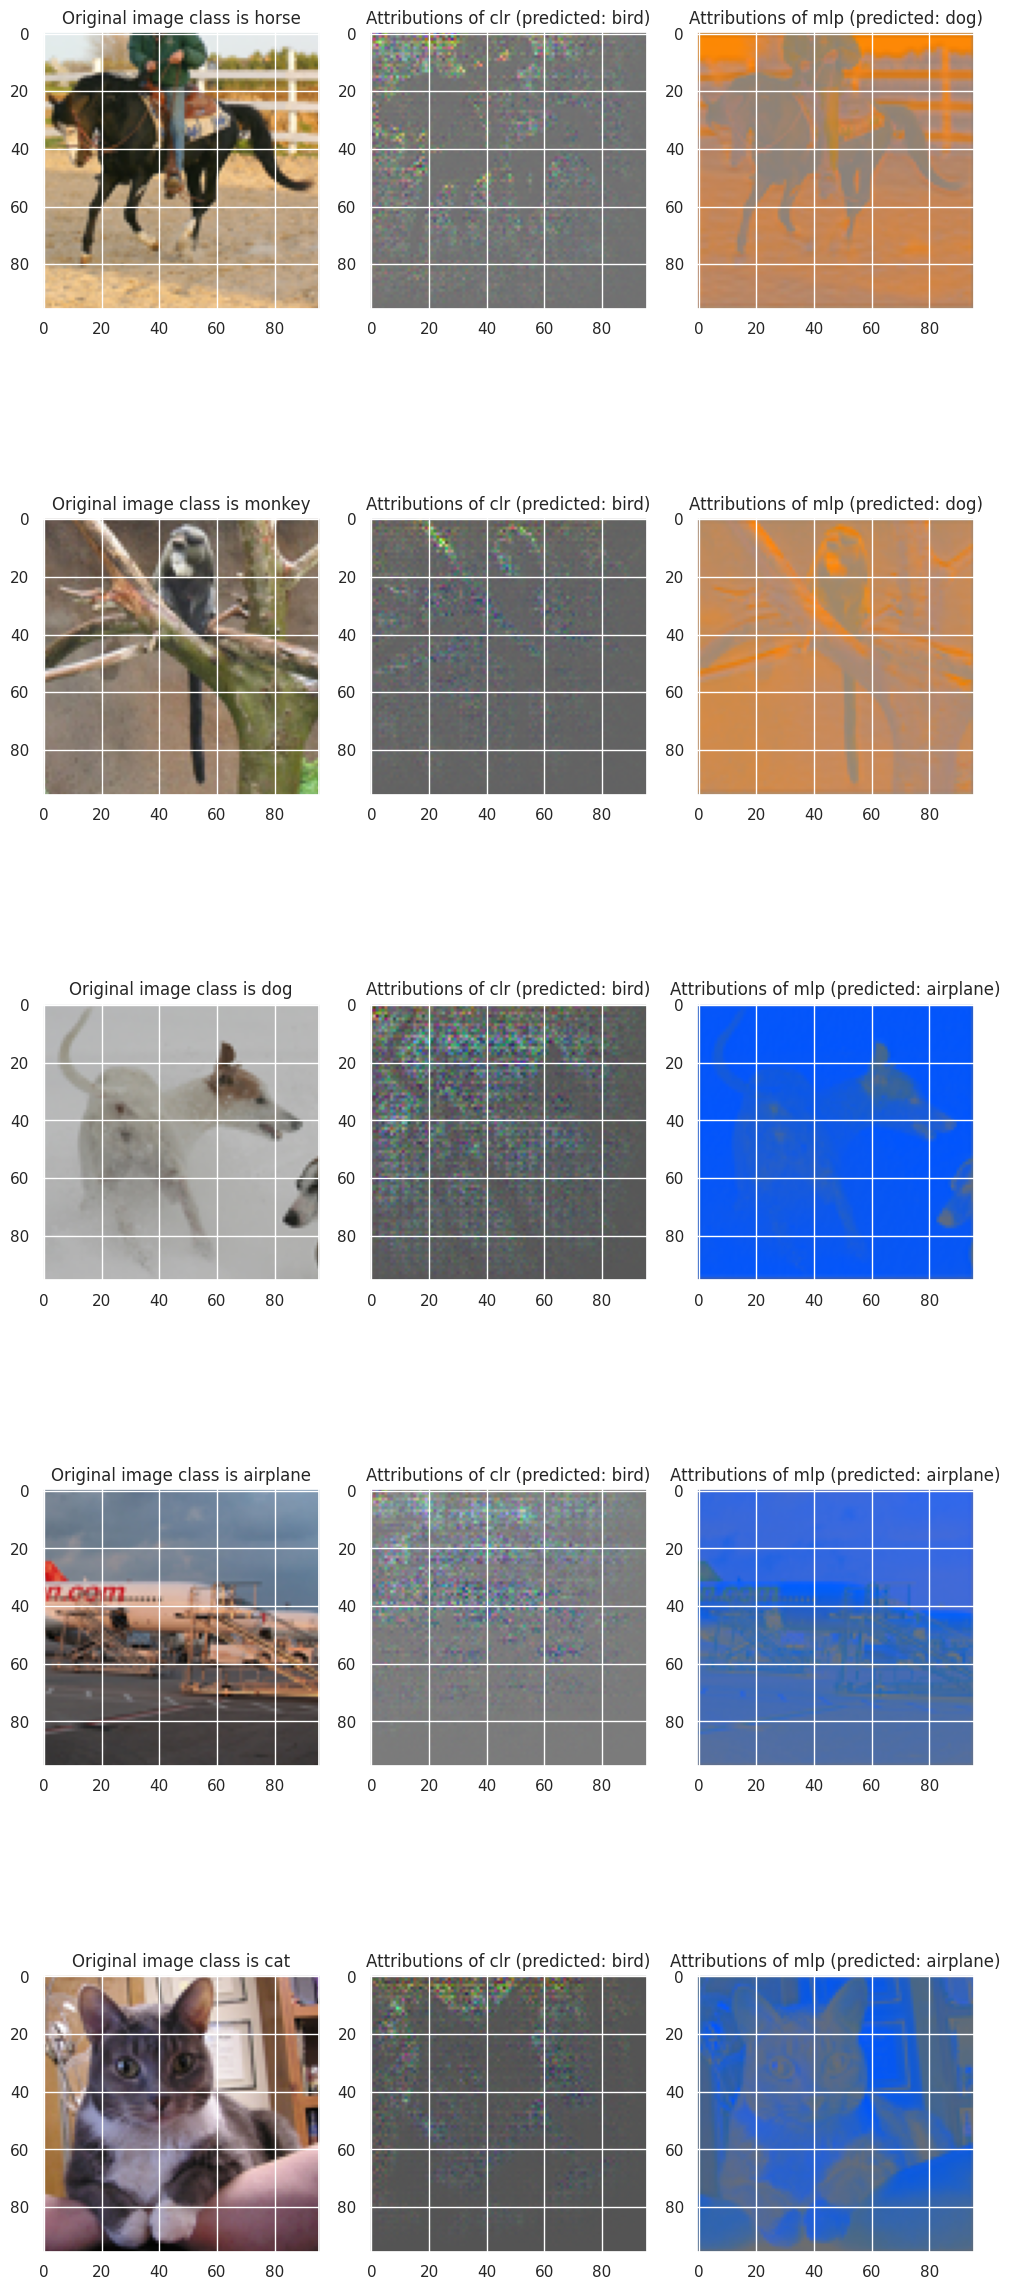

In [12]:
show_attributions(attributions=examples, model_names=models.keys(), save_fig=True)